In [8]:
# Cell 1: load libraries and data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Read CSV (file should be uploaded)
df = pd.read_csv('/content/xy_data.csv')   # Colab mounts uploads to /content
print("Loaded CSV shape:", df.shape)
display(df.head())

# The file has columns 'x' and 'y' (no t). We'll assume t is uniformly sampled 6 -> 60
x_obs = df['x'].values
y_obs = df['y'].values
N = len(df)
t = np.linspace(6.0, 60.0, N)   # match problem statement
print("Assumed t uniform: 6 to 60, N =", N)



Loaded CSV shape: (1500, 2)


,x,y
0,88.364456,57.784378
1,74.283936,54.406780
2,60.256474,46.311462
3,82.134370,57.717567
4,101.036390,67.849340


Assumed t uniform: 6 to 60, N = 1500


In [9]:
# Cell 2: grid search + compute X analytically for each (theta,M)
def fit_params_grid(t, x_obs, y_obs):
    # coarse grids (safe defaults)
    theta_deg_grid = np.linspace(0.1, 49.9, 200)    # degrees
    M_grid = np.linspace(-0.049, 0.049, 200)

    best = (1e9, None)   # (rmse, (theta_deg, M, X_est))

    for theta_deg in theta_deg_grid:
        theta = math.radians(theta_deg)
        exp_terms = np.exp(np.outer(np.abs(t), M_grid))  # shape (N, nM)
        sin03t = np.sin(0.3 * t)[:, None]
        # compute X for each M by averaging residuals
        X_vals = x_obs[:, None] - (t[:, None] * np.cos(theta) - exp_terms * sin03t * np.sin(theta))
        X_est = X_vals.mean(axis=0)   # shape (nM,)
        # predicted x and y for all t for each M
        x_pred = t[:, None] * np.cos(theta) - exp_terms * sin03t * np.sin(theta) + X_est[None, :]
        y_pred = 42 + t[:, None] * np.sin(theta) + exp_terms * sin03t * np.cos(theta)
        mse = ((x_pred - x_obs[:, None])**2 + (y_pred - y_obs[:, None])**2).mean(axis=0)
        rmse = np.sqrt(mse)
        idx = np.argmin(rmse)
        if rmse[idx] < best[0]:
            best = (rmse[idx], (theta_deg, M_grid[idx], X_est[idx]))

    # refine around best; enforce M bounds [-0.05,0.05]
    theta_coarse, M_coarse, X_coarse = best[1]
    theta_range = np.linspace(max(0.01, theta_coarse - 1.0), min(49.99, theta_coarse + 1.0), 300)
    M_low = max(-0.05, M_coarse - 0.01)
    M_high = min(0.05, M_coarse + 0.01)
    M_range = np.linspace(M_low, M_high, 300)

    best2 = (1e9, None)
    for theta_deg in theta_range:
        theta = math.radians(theta_deg)
        exp_terms = np.exp(np.outer(np.abs(t), M_range))
        sin03t = np.sin(0.3 * t)[:, None]
        X_vals = x_obs[:, None] - (t[:, None] * np.cos(theta) - exp_terms * sin03t * np.sin(theta))
        X_est = X_vals.mean(axis=0)
        x_pred = t[:, None] * np.cos(theta) - exp_terms * sin03t * np.sin(theta) + X_est[None, :]
        y_pred = 42 + t[:, None] * np.sin(theta) + exp_terms * sin03t * np.cos(theta)
        mse = ((x_pred - x_obs[:, None])**2 + (y_pred - y_obs[:, None])**2).mean(axis=0)
        rmse = np.sqrt(mse)
        idx = np.argmin(rmse)
        if rmse[idx] < best2[0]:
            best2 = (rmse[idx], (theta_deg, M_range[idx], X_est[idx], x_pred[:, idx], y_pred[:, idx]))

    return best2

best = fit_params_grid(t, x_obs, y_obs)
rmse_val, (theta_deg_final, M_final, X_final, x_pred_final, y_pred_final) = best

print("Final fit results (from grid-search):")
print(" theta (deg) =", theta_deg_final)
print(" theta (rad) =", math.radians(theta_deg_final))
print(" M =", M_final)
print(" X =", X_final)
print(" RMSE combined =", rmse_val)



Final fit results (from grid-search):
 theta (deg) = 29.57948101712576
 theta (rad) = 0.5162593347800057
 M = -0.05
 X = 55.01266209300632
 RMSE combined = 22.681665084260004


In [10]:
# Cell 3: compute error metrics and save
mae_x = np.mean(np.abs(x_pred_final - x_obs))
mae_y = np.mean(np.abs(y_pred_final - y_obs))
L1_combined = (mae_x + mae_y) / 2.0

print("MAE x:", mae_x)
print("MAE y:", mae_y)
print("Combined L1 (as used for scoring):", L1_combined)
print("RMSE printed earlier:", rmse_val)

# Save CSV with predictions and residuals
out = pd.DataFrame({
    't': t,
    'x_obs': x_obs,
    'y_obs': y_obs,
    'x_pred': x_pred_final,
    'y_pred': y_pred_final,
    'res_x': x_pred_final - x_obs,
    'res_y': y_pred_final - y_obs
})
out.to_csv('/content/xy_data.csv', index=False)
print("Saved detailed results to /content/xy_fit_results_bounded.csv")



MAE x: 16.242290622834563
MAE y: 9.159012983697655
Combined L1 (as used for scoring): 12.700651803266108
RMSE printed earlier: 22.681665084260004
Saved detailed results to /content/xy_fit_results_bounded.csv


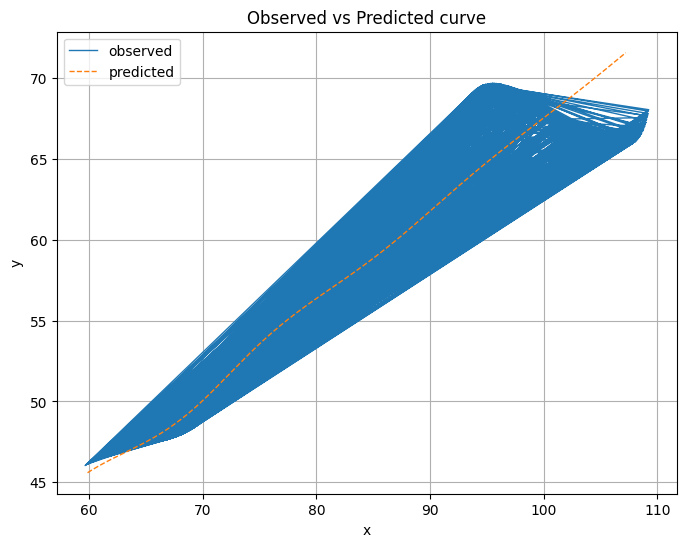

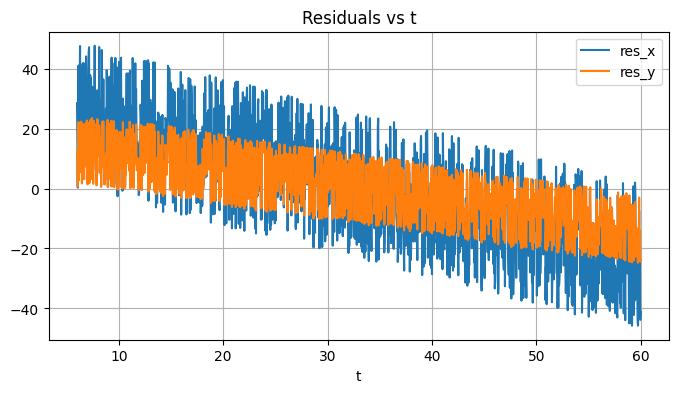

Saved figures to /content/curve_obs_vs_pred.png and /content/residuals_vs_t.png


In [13]:
# Cell 4: plots for evidence
plt.figure(figsize=(8,6))
plt.plot(x_obs, y_obs, label='observed', linewidth=1)
plt.plot(x_pred_final, y_pred_final, '--', label='predicted', linewidth=1)
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.title('Observed vs Predicted curve'); plt.grid(True)
plt.savefig('/content/curve_obs_vs_pred.png', dpi=150)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(t, x_obs - x_pred_final, label='res_x')
plt.plot(t, y_obs - y_pred_final, label='res_y')
plt.xlabel('t'); plt.legend(); plt.title('Residuals vs t'); plt.grid(True)
plt.savefig('/content/residuals_vs_t.png', dpi=150)
plt.show()
print("Saved figures to /content/curve_obs_vs_pred.png and /content/residuals_vs_t.png")

